In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock


In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
sns.set_style("whitegrid")

In [47]:
def calc_SA(trj, helix, start, stop):
    RMS_start = start
    RMS_stop = stop
    RMS = []
    for i in range(RMS_start, RMS_stop):
        sel = helix.topology.select("resid %s to %s and name CA" %
                                    (i, i + 6))
        rmsd = md.rmsd(trj, helix, atom_indices=sel)
        RMS.append(rmsd)
    RMS = np.asarray(RMS)
    Sa_sum = np.zeros((trj.n_frames))
    Sa = (1.0 - (RMS / 0.08)**8) / (1 - (RMS / 0.08)**12)
    return Sa


def calc_Rg(trj):
    mass = []
    for at in trj.topology.atoms:
        mass.append(at.element.mass)
    mass_CA = len(mass) * [0.0]
    for i in trj.topology.select("name CA"):
        mass_CA[i] = 1.0
    rg_CA = md.compute_rg(trj, masses=np.array(mass_CA))
    return rg_CA


def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(a,
                                                 b,
                                                 30, [[y0, ymax], [x0, xmax]],
                                                 normed=True,
                                                 weights=None)
    free_energy = np.log(np.flipud(free_energy) + .000001)
    free_energy = -(0.001987 * T) * free_energy
    return free_energy, xedges, yedges


def free_energy_reweight(a, b, T, y0, ymax, x0, xmax, weight):
    free_energy, xedges, yedges = np.histogram2d(a,
                                                 b,
                                                 30, [[y0, ymax], [x0, xmax]],
                                                 normed=True,
                                                 weights=weight)
    free_energy = np.log(np.flipud(free_energy) + .000001)
    free_energy = -(0.001987 * T) * free_energy
    return free_energy, xedges, yedges


def free_energy_1D_noscale(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(a,
                                       bins=bins,
                                       range=[x0, xmax],
                                       density=True,
                                       weights=None)
    free_energy = np.log(free_energy + .000001)
    free_energy = -(0.001987 * T) * free_energy
    xcenters = xedges[:-1] + np.diff(xedges) / 2
    return free_energy, xcenters


def free_energy_1D(a, T, x0, xmax, bins):
    free_energy, xedges = np.histogram(a,
                                       bins=bins,
                                       range=[x0, xmax],
                                       density=True,
                                       weights=None)
    max = np.max(free_energy)
    free_energy = np.log(free_energy + .0000001)
    free_energy = -(0.001987 * T) * (free_energy - np.log(max + .0000001))
    xcenters = xedges[:-1] + np.diff(xedges) / 2
    return free_energy, xcenters


def free_energy_1D_reweight(a, T, x0, xmax, bins, weight):
    free_energy, xedges = np.histogram(a,
                                       bins=bins,
                                       range=[x0, xmax],
                                       density=True,
                                       weights=weight)
    max = np.max(free_energy)
    free_energy = np.log(free_energy + .0000001)
    free_energy = -(0.001987 * T) * (free_energy - np.log(max + .0000001))
    xcenters = xedges[:-1] + np.diff(xedges) / 2
    return free_energy, xcenters


def alphabeta_rmsd(phi, psi, phi_ref, psi_ref):
    alphabetarmsd = np.sum(0.5 * (1 + np.cos(psi - psi_ref)), axis=1) + np.sum(
        0.5 * (1 + np.cos(phi - phi_ref)), axis=1)
    return alphabetarmsd


def dssp_convert(dssp):
    dsspH = np.copy(dssp)
    dsspE = np.copy(dssp)
    dsspH[dsspH == 'H'] = 1
    dsspH[dsspH == 'E'] = 0
    dsspH[dsspH == 'C'] = 0
    dsspH[dsspH == 'NA'] = 0
    dsspH = dsspH.astype(int)
    TotalH = np.sum(dsspH, axis=1)
    SE_H = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspH[:, i].astype(float)
        if (np.mean(data) > 0):
            SE_H[i] = [np.mean(data), (block(data))**.5]

    dsspE[dsspE == 'H'] = 0
    dsspE[dsspE == 'E'] = 1
    dsspE[dsspE == 'C'] = 0
    dsspE[dsspE == 'NA'] = 0
    dsspE = dsspE.astype(int)
    TotalE = np.sum(dsspE, axis=1)
    Eprop = np.sum(dsspE, axis=0).astype(float) / len(dsspE)
    SE_E = np.zeros((len(dssp[0]), 2))

    for i in range(0, len(dssp[0])):
        data = dsspE[:, i].astype(float)
        if (np.mean(data) > 0):
            SE_E[i] = [np.mean(data), (block(data))**.5]
    return SE_H, SE_E


def calc_phipsi(trj):
    indices_phi, phis = md.compute_phi(trj)
    indices_psi, psis = md.compute_psi(trj)
    phi_label = []
    for i_phi in range(0, indices_phi.shape[0]):
        resindex = trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
        phi_label.append(resindex)
    phi_label = np.array(phi_label)
    #print(phi_label)
    psi_label = []
    for i_psi in range(0, indices_psi.shape[0]):
        resindex = trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
        psi_label.append(resindex)
    psi_label = np.array(psi_label)
    #print(psi_label)
    phipsi = []
    for i in range(0, len(phi_label) - 1):
        current_phipsi = np.column_stack((phis[:, i + 1], psis[:, i]))
        phipsi.append(current_phipsi)
    phipsi_array = np.array(phipsi)
    return (phipsi_array, psi_label, phi_label)


In [42]:
def block(x):
    # preliminaries
    d = log2(len(x))
    if (d - floor(d) != 0):
        #    print("Warning: Data size = %g, is not a power of 2." % floor(2**d))
        #    print("Truncating data to %g." % 2**floor(d) )
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    # estimate the auto-covariance and variances
    # for each blocking transformation
    for i in arange(0, d):
        n = len(x)
        # estimate autocovariance of x
        gamma[i] = (n)**(-1) * sum((x[0:(n - 1)] - mu) * (x[1:n] - mu))
        # estimate variance of x
        s[i] = var(x)
        # perform blocking transformation
        x = 0.5 * (x[0::2] + x[1::2])

    # generate the test observator M_k from the theorem
    M = (cumsum(((gamma / s)**2 * 2**arange(1, d + 1)[::-1])[::-1]))[::-1]

    # we need a list of magic numbers
    q = array([
        6.634897, 9.210340, 11.344867, 13.276704, 15.086272, 16.811894,
        18.475307, 20.090235, 21.665994, 23.209251, 24.724970, 26.216967,
        27.688250, 29.141238, 30.577914, 31.999927, 33.408664, 34.805306,
        36.190869, 37.566235, 38.932173, 40.289360, 41.638398, 42.979820,
        44.314105, 45.641683, 46.962942, 48.278236, 49.587884, 50.892181
    ])

    # use magic to determine when we should have stopped blocking
    for k in arange(0, d):
        if (M[k] < q[k]):
            break
    if (k >= d - 1):
        print("Warning: Use more data")

    return (s[k] / 2**(d - k))

def free_energy_1D_blockerror(a, T, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    max = np.max(histo)
    free_energy = -(0.001987*T)*np.log(histo+.000001)
    free_energy = free_energy-np.min(free_energy)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    ferr = -(0.001987*T)*(error / average)
    return free_energy, xcenters, ferr


def chunkIt(a, num):
    avg = a / float(num)
    out = []
    last = 0.0
    while last < a-1:
        out.append([int(last), int(last+avg)])
        last += avg
    return out


def histo_blockerror(a, x0, xmax, bins, blocks):
    histo, xedges = np.histogram(
        a, bins=bins, range=[x0, xmax], density=True, weights=None)
    xcenters = xedges[:-1] + np.diff(xedges)/2
    Ind = chunkIt(len(a), blocks)
    block_size = (Ind[0][1]-Ind[0][0])
    hist_blocks = []
    for i in range(0, len(Ind)):
        block_data = a[Ind[i][0]:Ind[i][1]]
        hist, binedges = np.histogram(block_data, bins=bins, range=[
                                      x0, xmax], density=True, weights=None)
        hist_blocks.append(hist)
    hist_blocks = np.array(hist_blocks)
    average = np.average(hist_blocks, axis=0)
    variance = np.var(hist_blocks, axis=0)
    N = len(hist_blocks)
    error = np.sqrt(variance / N)
    return average, xcenters, error


def Kd_calc(bound, conc):
    return((1-bound)*conc/bound)


def get_blockerrors(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        be = block(data)**.5
        ave.append(np.average(data))
        block_errors.append(be)
    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac

    return ave_bf, be_bf


def get_blockerrors_pyblock(Data, bound_frac):
    n_data = len(Data[0])
    block_errors = []
    ave = []
    for i in range(0, n_data):
        data = Data[:, i]
        average = np.average(data)
        if (average != 0) and (average != 1):
            reblock_data = pyblock.blocking.reblock(data)
            opt = pyblock.blocking.find_optimal_block(
                len(data), reblock_data)[0]
            opt_block = reblock_data[opt]
            be = opt_block[4]
        else:
            be = 0
        ave.append(average)
        block_errors.append(be)

    ave_bf = np.asarray(ave)/bound_frac
    be_bf = np.asarray(block_errors)/bound_frac
    return ave_bf, be_bf


def get_blockerror(Data):
    data = Data
    average = np.average(data)
    be = block(data)**.5
    return average, be


def get_blockerror_pyblock(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)


def get_blockerror_pyblock_nanskip(Data):
    average = np.average(Data)
    if (average != 0) and (average != 1):
        reblock_data = pyblock.blocking.reblock(Data)
        opt = pyblock.blocking.find_optimal_block(len(Data), reblock_data)[0]
        if(math.isnan(opt)):
            be_max = 0
            for i in range(0, len(reblock_data)):
                be = reblock_data[i][4]
                if(be > be_max):
                    be_max = be
        else:
            be = reblock_data[opt][4]
    else:
        be = 0
    return average, float(be)

In [34]:
trajdir = '/home/jaya/work/p53/prot_only/data_rest/'
outdir = trajdir+'data/'
helixpdb = './p53_allhelix.pdb'
ppII='./pp_p53.pdb'
pdb = trajdir+'pbc.pdb'
trajectory = trajdir + 'pbc.xtc'

print("workdir", outdir)
print("pdb", pdb)
print("trjaectory", trajectory)


workdir /home/jaya/work/p53/prot_only/data_rest/data/
pdb /home/jaya/work/p53/prot_only/data_rest/pbc.pdb
trjaectory /home/jaya/work/p53/prot_only/data_rest/pbc.xtc


In [6]:
trj = md.load(trajectory, top=pdb, stride=1)
trj.center_coordinates()
top = trj.topology
#top = trj.topology.subset(trj.topology.select("not name Na "))
#top = trj.topology(trj.topology.select("not name NA CL"))
first_frame = 0
last_frame = trj.n_frames
n_frames = trj.n_frames
print(top)
trj

<mdtraj.Topology with 1 chains, 61 residues, 926 atoms, 941 bonds>


<mdtraj.Trajectory with 13712 frames, 926 atoms, 61 residues, and unitcells at 0x7f5aba969070>

In [7]:
nres = []
for res in trj.topology.residues:
    nres.append(res.resSeq)
sequence = (' %s' % [residue for residue in trj.topology.residues])
resname = (' %s' % [residue.name for residue in trj.topology.residues])
resindex = (' %s' % [residue.index for residue in trj.topology.residues])
prot_top = top.subset(top.select('protein'))
prot_res = []
for res in prot_top.residues:
    prot_res.append(res.resSeq)
prot_resname = (' %s' % [residue.name for residue in prot_top.residues])
residues = len(set(prot_res))

#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

residues = 61
residue_offset = 0
prot_res_renum = np.asarray(prot_res) + residue_offset
residue_number = range(0, residues)
residue_number_offsetres = range(residue_offset, residue_offset + residues)
print("Residue Number Range:", residue_number)

sequence = []
for residue in trj.topology.residues:
    index = residue.index
    renum = int(index) + residue_offset
    sequence.append(residue.name + "%s" % (renum))
print(len(sequence))
print(sequence)

frames = trj.n_frames
half = int(np.floor(frames / 2))


** SYSTEM INFO **

Number of atoms: 926

Number of residues: 61

Number of protein residues: 61

Number of frames: 13712

Starting frame: 0

Last frame: 13712

sequence:  [MET1, GLU2, GLU3, PRO4, GLN5, SER6, ASP7, PRO8, SER9, VAL10, GLU11, PRO12, PRO13, LEU14, SER15, GLN16, GLU17, THR18, PHE19, SER20, ASP21, LEU22, TRP23, LYS24, LEU25, LEU26, PRO27, GLU28, ASN29, ASN30, VAL31, LEU32, SER33, PRO34, LEU35, PRO36, SER37, GLN38, ALA39, MET40, ASP41, ASP42, LEU43, MET44, LEU45, SER46, PRO47, ASP48, ASP49, ILE50, GLU51, GLN52, TRP53, PHE54, THR55, GLU56, ASP57, PRO58, GLY59, PRO60, ASP61]

residue names:  ['MET', 'GLU', 'GLU', 'PRO', 'GLN', 'SER', 'ASP', 'PRO', 'SER', 'VAL', 'GLU', 'PRO', 'PRO', 'LEU', 'SER', 'GLN', 'GLU', 'THR', 'PHE', 'SER', 'ASP', 'LEU', 'TRP', 'LYS', 'LEU', 'LEU', 'PRO', 'GLU', 'ASN', 'ASN', 'VAL', 'LEU', 'SER', 'PRO', 'LEU', 'PRO', 'SER', 'GLN', 'ALA', 'MET', 'ASP', 'ASP', 'LEU', 'MET', 'LEU', 'SER', 'PRO', 'ASP', 'ASP', 'ILE', 'GLU', 'GLN', 'TRP', 'PHE', 'THR', 'GLU', 

/tmp/ipykernel_22236/2298805374.py:24: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma / s)**2 * 2**arange(1, d + 1)[::-1])[::-1]))[::-1]


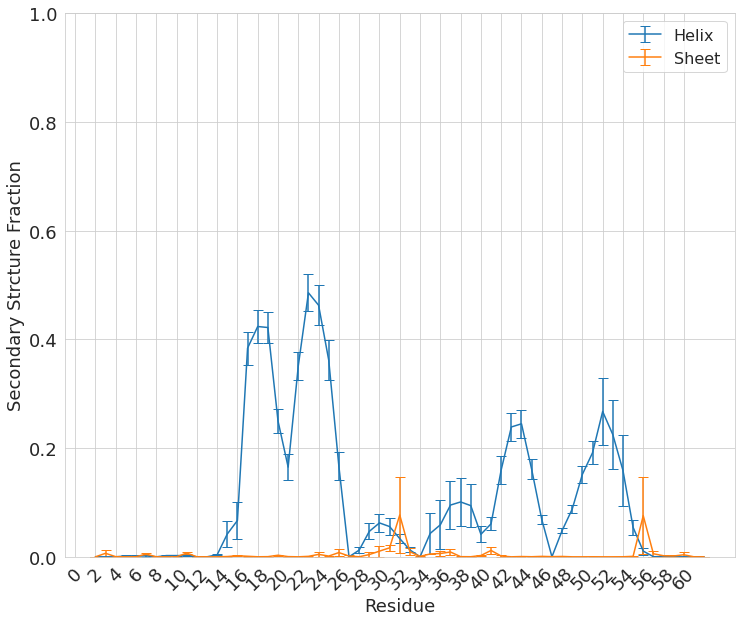

In [15]:
trjH1 = md.load(trajectory, top=pdb, stride=1)
H1 = top.select("resid 0 to 60")
trjH1.restrict_atoms(H1)
trjH1.center_coordinates()
frames = trjH1.n_frames
half = int(np.floor(frames/2))

h_res = []
for res in trjH1.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 1
hres_renum = np.asarray(h_res)+residue_offset


frames = trj.n_frames
half = int(np.floor(frames/2))

dsspH1 = md.compute_dssp(trjH1, simplified=True)
dsspH1_h2 = md.compute_dssp(trjH1[half:-1], simplified=True)
dsspH1_h1 = md.compute_dssp(trjH1[0:half], simplified=True)

H1_H, H1_E = dssp_convert(dsspH1)
H1_H_h2, H1_E_h2 = dssp_convert(dsspH1_h2)
H1_H_h1, H1_E_h1 = dssp_convert(dsspH1_h1)

plt.figure(figsize=(12,10))
plt.errorbar(hres_renum, H1_H[:, 0], yerr=H1_H[:, 1], capsize=5, label='Helix')

plt.errorbar(hres_renum, H1_E[:, 0], yerr=H1_E[:, 1], capsize=5, label='Sheet')

plt.ylim(0, 1.0)
plt.xticks(range(0,62,2),rotation=45)
plt.legend(loc="upper right",fontsize=16)
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)
np.savetxt(outdir+'Hprop.err.dat',
           np.column_stack((hres_renum, H1_H[:, 0], H1_H[:, 1])))
np.savetxt(outdir+'Eprop.err.dat',
           np.column_stack((hres_renum, H1_E[:, 0], H1_E[:, 1])))


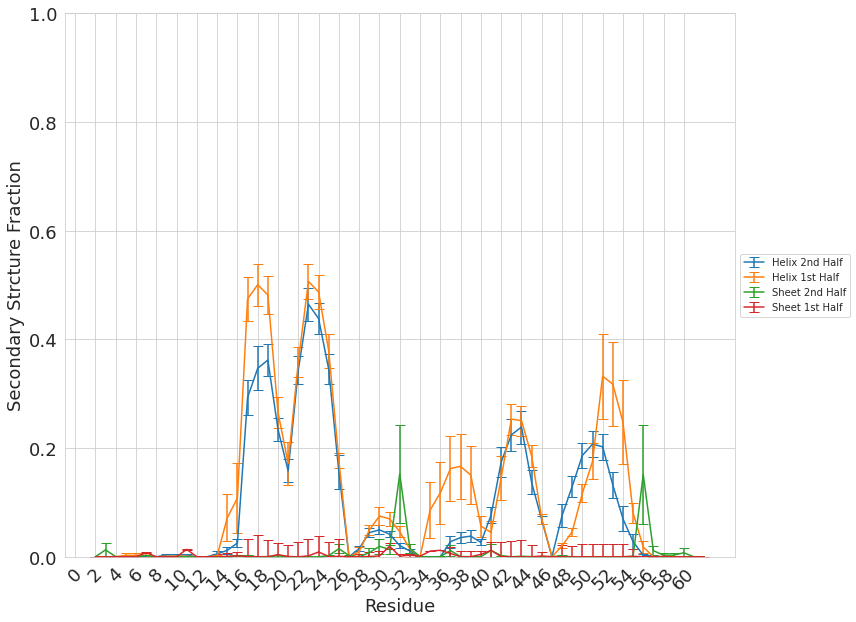

In [18]:
plt.figure(figsize=(12,10))

plt.errorbar(
    hres_renum, H1_H_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Helix 2nd Half')
plt.errorbar(
    hres_renum, H1_H_h1[:, 0], yerr=H1_H_h1[:, 1], capsize=5, label='Helix 1st Half')

plt.errorbar(
    hres_renum, H1_E_h1[:, 0], yerr=H1_E_h1[:, 1], capsize=5, label='Sheet 2nd Half')
plt.errorbar(
    hres_renum, H1_E_h2[:, 0], yerr=H1_H_h2[:, 1], capsize=5, label='Sheet 1st Half')


plt.ylim(0, 1.0)
plt.xticks(range(0,62,2),rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [19]:
dsspH = np.copy(dsspH1)
dsspH[dsspH == 'H'] = 1
dsspH[dsspH == 'E'] = 0
dsspH[dsspH == 'C'] = 0
dsspH[dsspH == 'NA'] = 0
dsspH = dsspH.astype(int)
TotalH = np.sum(dsspH, axis=1)
np.shape(dsspH1)
TotalH
print("Average Helical Residues:%6.3lf" %
      (np.average(TotalH)), "+_%6.3lf" % ((block(TotalH)**.5)))
print("Average Fraction Helix:%6.3lf" %
      (np.average(TotalH)/56.0), "+_%6.3lf" % ((block(TotalH)**.5)/56.0))

Average Helical Residues: 6.382 +_ 0.370
Average Fraction Helix: 0.114 +_ 0.007


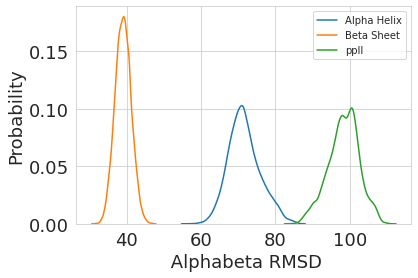

In [20]:
#Compute Phi and Psi
#phipsi_array,psi_labels,phi_labels=calc_phipsi(trj)
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)

Phi_all = phis
Psi_all = psis
alphabeta_alpharight = alphabeta_rmsd(Phi_all, Psi_all, -1.05, -0.79)
alphabeta_betasheet = alphabeta_rmsd(Phi_all, Psi_all, 2.36, -2.36)
alphabeta_ppII = alphabeta_rmsd(Phi_all, Psi_all, -1.31, 2.71)

#sns.set(style='whitegrid')
sns.kdeplot(data=alphabeta_alpharight, label='Alpha Helix')
sns.kdeplot(data=alphabeta_betasheet, label='Beta Sheet')
sns.kdeplot(data=alphabeta_ppII, label='ppII')

plt.xlabel(' Alphabeta RMSD', fontsize=18)
plt.ylabel('Probability', fontsize=18)
#plt.xlim(20,100)
#plt.ylim(0,0.25)

plt.legend(loc='upper right')
plt.tick_params(labelsize=18)

plt.show()

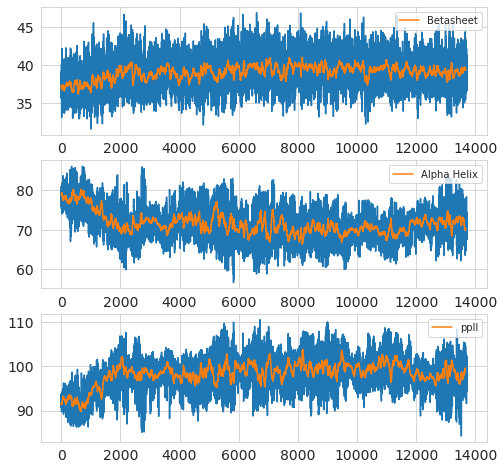

In [21]:
fig, ax = plt.subplots(3, figsize=((8, 8)))
N = 50
ax[0].plot(alphabeta_betasheet)
ax[0].plot(np.convolve(alphabeta_betasheet, np.ones(N) / N, mode='valid'),
           label='Betasheet')
ax[0].legend(loc='upper right')

ax[1].plot(alphabeta_alpharight)
ax[1].plot(np.convolve(alphabeta_alpharight, np.ones(N) / N, mode='valid'),
           label='Alpha Helix')
ax[1].legend(loc='upper right')

ax[2].plot(alphabeta_ppII)
ax[2].plot(np.convolve(alphabeta_ppII, np.ones(N) / N, mode='valid'),
           label='ppII')
ax[2].legend(loc='upper right')

ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[2].tick_params(labelsize=14)


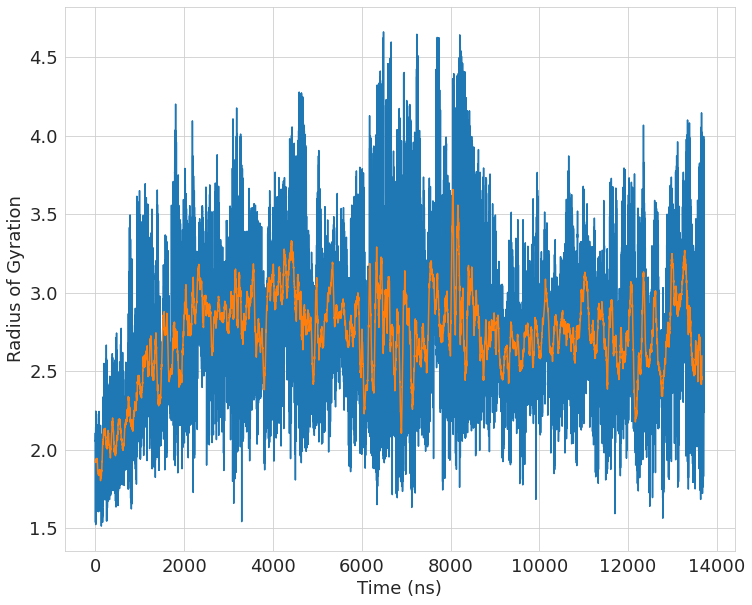

CA Radius of Gyration All: 2.731 +_ 0.050


In [22]:
rg = calc_Rg(trj)
N = 50

plt.figure(figsize=(12,10))
plt.plot(rg)
plt.plot(np.convolve(rg, np.ones(N) / N, mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.tick_params(labelsize=18)

plt.show()
print("CA Radius of Gyration All:%6.3lf" % np.average(rg),
      "+_%6.3lf" % block(rg)**.5)


helixBB = md.load_pdb(helixpdb)
trjBB = md.load(trajectory, top=pdb, stride=20)
#trajBB = trj
BB = trjBB.topology.select("residue 0 to 60 and name CA")
HBB = helixBB.topology.select("residue 0 to 60 and name CA")

trjBB.restrict_atoms(BB)
helixBB.restrict_atoms(HBB)
trjBB.center_coordinates()
helixBB.center_coordinates()

Sa = calc_SA(trjBB, helixBB, 0, 55)
Sa_total = np.sum(Sa, axis=0)
Sa_ave = np.average(Sa, axis=1)

Sa_H1 = calc_SA(trjBB, helixBB, 0, 14)
Sa_total_H1 = np.sum(Sa_H1, axis=0)
Sa_ave_H1 = np.average(Sa_H1, axis=1)

Sa_H2 = calc_SA(trjBB, helixBB, 21, 25)
Sa_total_H2 = np.sum(Sa_H2, axis=0)
Sa_ave_H2 = np.average(Sa_H2, axis=1)

Sa_H3 = calc_SA(trjBB, helixBB, 32, 55)
Sa_total_H3 = np.sum(Sa_H3, axis=0)
Sa_ave_H3 = np.average(Sa_H3, axis=1)

plt.figure(figsize=(12,10))
N = 10
plt.plot(np.convolve(Sa_total, np.ones(N) / N, mode='valid'), label='Full', c='orange')
plt.plot(np.convolve(Sa_total_H1, np.ones(N) / N, mode='valid'), label='H1', c='r')
plt.plot(np.convolve(Sa_total_H2, np.ones(N) / N, mode='valid'), label='H2', c='b')
plt.plot(np.convolve(Sa_total_H3, np.ones(N) / N, mode='valid'), label='H3', c='g')

plt.legend(fontsize=16)
plt.xlabel('Time (ns)', size=18)
plt.ylabel('AlphaRMSD', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.show()

Number of residues: 61

Sα: 0.066 +_ 0.002


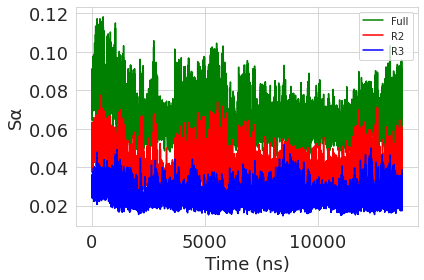

In [52]:
helix = md.load_pdb(helixpdb)
helix
top_helix = helix.topology
backbone_helix = top_helix.select("name CA")
backbone = top.select("name CA")

sel1 = top_helix.select("resid 0 to 31 and name CA")
sel2 = top_helix.select("resid 32 to 60 and name CA")

print("Number of residues: %d\n" % len(set(nres)))
RMS_start = 1
RMS_stop = 54
RMS = []
for i in range(RMS_start, RMS_stop):
    sel = top_helix.select("resid %s to %s and backbone" % (i, i+6))
    rmsd = md.rmsd(trj, helix, atom_indices=sel)
    RMS.append(rmsd)
RMS = np.asarray(RMS)
RMS

Sa_sum = np.zeros((trj.n_frames))
Sa = (1.0-(RMS/0.08)**8)/(1-(RMS/0.08)**12)
Sa_ave = np.average(Sa, axis=1)
Sa_total = np.sum(Sa, axis=0)
Sa_R2 = np.sum(Sa[0:31], axis=0)
Sa_R3 = np.sum(Sa[32:60], axis=0)

print("Sα:%6.3lf" % np.average(Sa_total),
      "+_%6.3lf" % block(Sa_total)**.5)

N = 100
plt.plot(Sa_total, label='Full', c='g')
plt.plot(Sa_R2, label='R2', c='r')
plt.plot(Sa_R3, label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
#plt.ylim(0, 1)
plt.savefig(outdir+'Sa.timecourse.png')
np.savetxt(outdir+'Sa_total.dat', Sa_total)
np.savetxt(outdir+'Sa_total.R2.dat', Sa_R2)
np.savetxt(outdir+'Sa_total.R3.dat', Sa_R3)

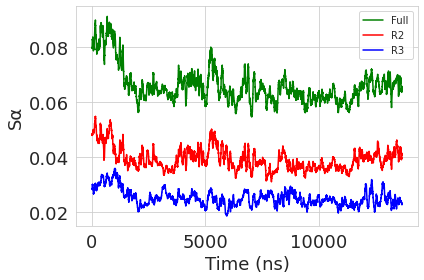

In [53]:
N = 50
plt.plot(np.convolve(Sa_total, np.ones(N)/N, mode='valid'), label='Full', c='g')
plt.plot(np.convolve(Sa_R2, np.ones(N)/N, mode='valid'), label='R2', c='r')
plt.plot(np.convolve(Sa_R3, np.ones(N)/N, mode='valid'), label='R3', c='b')
plt.legend()
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Sα', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
#plt.ylim(0, 1)
plt.savefig(outdir+'Sa.timecourse.smooth.png')

In [54]:
contact_maps = []
contact_distances = []
for i in range(0, 61):
    contact_map = []
    contact_distance = []
    for j in range(0, 61):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 1.2, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

In [55]:
sequence = []
for residue in trj.topology.residues:
    index = residue.index
    renum = int(index) + residue_offset
    sequence.append(residue.name + "%s" % (renum))
print(len(sequence))
print(sequence)


61
['MET1', 'GLU2', 'GLU3', 'PRO4', 'GLN5', 'SER6', 'ASP7', 'PRO8', 'SER9', 'VAL10', 'GLU11', 'PRO12', 'PRO13', 'LEU14', 'SER15', 'GLN16', 'GLU17', 'THR18', 'PHE19', 'SER20', 'ASP21', 'LEU22', 'TRP23', 'LYS24', 'LEU25', 'LEU26', 'PRO27', 'GLU28', 'ASN29', 'ASN30', 'VAL31', 'LEU32', 'SER33', 'PRO34', 'LEU35', 'PRO36', 'SER37', 'GLN38', 'ALA39', 'MET40', 'ASP41', 'ASP42', 'LEU43', 'MET44', 'LEU45', 'SER46', 'PRO47', 'ASP48', 'ASP49', 'ILE50', 'GLU51', 'GLN52', 'TRP53', 'PHE54', 'THR55', 'GLU56', 'ASP57', 'PRO58', 'GLY59', 'PRO60', 'ASP61']


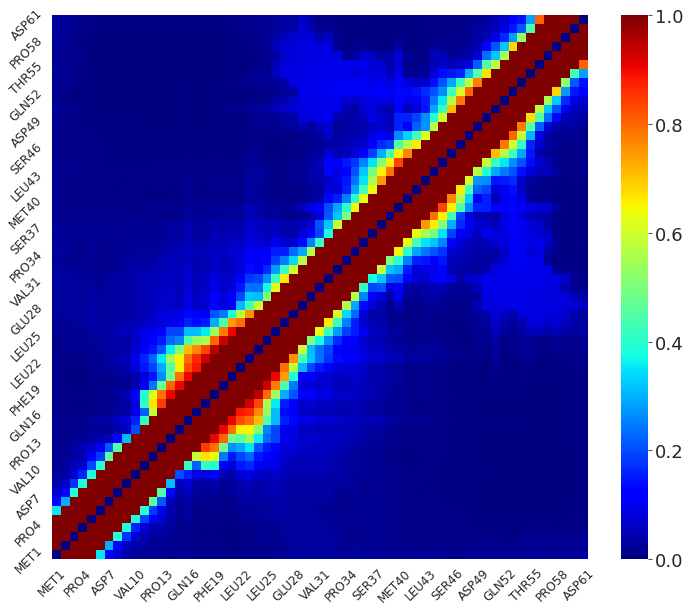

In [56]:
sequence = []
for residue in trj.topology.residues:
    index = residue.index
    renum = int(index) + residue_offset
    sequence.append(residue.name + "%s" % (renum))

n = 3
for i in range(0, len(sequence)):
    if (i % n != 0):
        sequence[i] = ''
contact_map = final_map

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
im = sns.heatmap(contact_map, cmap='jet', ax=ax)
ax.grid(which='both', alpha=0.5)
plt.xticks(range(0, 61), sequence, rotation=45, size=12)
plt.yticks(range(0, 61), sequence, rotation=45, size=12)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=18)
ax.invert_yaxis()

plt.savefig(outdir + 'contact_map.png')
#plt.savefig(outdir + 'contact_map.pdf')
plt.show()

53


<Figure size 432x288 with 0 Axes>

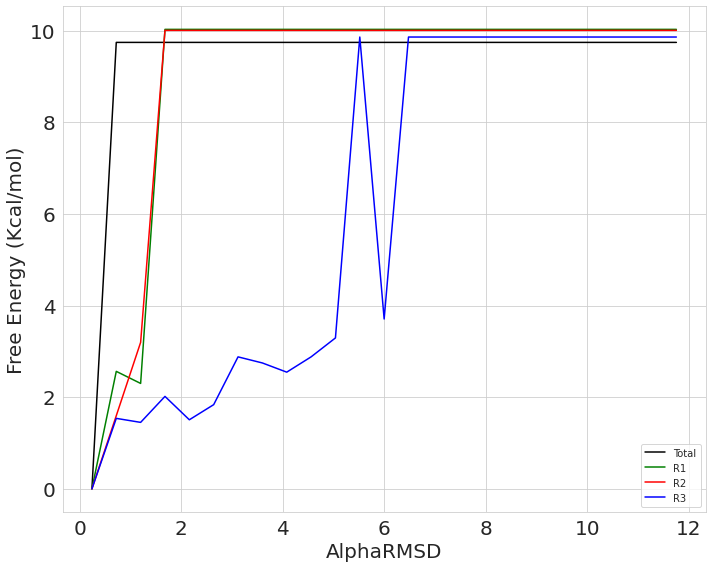

In [57]:
print(len(Sa))
Sa_dg, edges = free_energy_1D(Sa_total, 300, 0, 20, 25)
Sa1_dg, edges = free_energy_1D(Sa_total_H1, 300, 0, 12, 25)
Sa2_dg, edges = free_energy_1D(Sa_total_H2, 300, 0, 12, 25)
Sa3_dg, edges = free_energy_1D(Sa_total_H3, 300, 0, 12, 25)

plt.clf()
plt.figure(figsize=(10,8))
plt.plot(edges, Sa_dg, c='black', label='Total')
plt.plot(edges, Sa1_dg, c='g', label='R1')
plt.plot(edges, Sa2_dg, c='r', label='R2')
plt.plot(edges, Sa3_dg, c='b', label='R3')

plt.legend()

#plt.ylim(0, 5)
#xlim(0, 15)
plt.xlabel('AlphaRMSD', size=20)
plt.ylabel('Free Energy (Kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='20')
plt.yticks(size='20')
plt.tight_layout()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('%s/Sa.dG.png' % outdir)


/tmp/ipykernel_22236/3669321717.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),


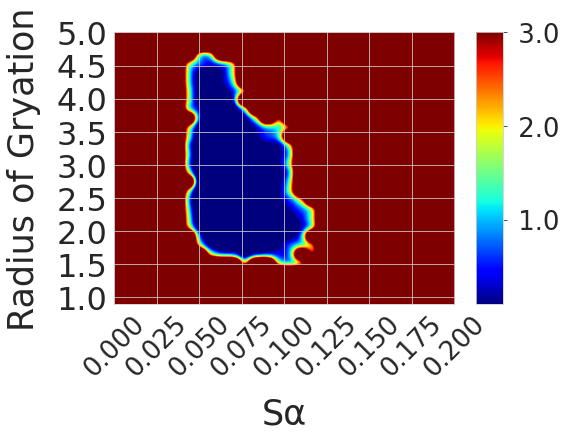

In [70]:
a, xedges, yedges = np.histogram2d(
    rg, Sa_total, 30, [[0.9, 5.0], [0, 0.2]], normed=True, weights=None)
a = np.log(np.flipud(a)+.000001)
T = 300
a = -(0.001987*T)*a

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(a, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5]
#plt.xlim(0, 24.9)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Radius of Gryation", size=35, labelpad=15)
plt.xlabel("Sα", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26',rotation=45)
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')


plt.tight_layout()
np.savetxt(outdir+'Apo.Rg_v_Sa.dG.dat', a)
plt.savefig(outdir+'Apo.Rg_v_Sa.dG.pdf')

/tmp/ipykernel_22236/55530361.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),


<Figure size 432x288 with 0 Axes>

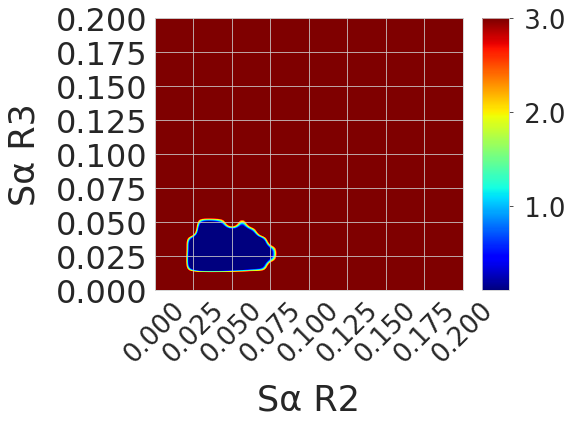

In [73]:
dG, xedges, yedges = free_energy(Sa_R3, Sa_R2, 300, 0, 0.2, 0, 0.2)

# a,xedges,yedges=np.histogram2d(Sa_total_H2,Sa_total_H1,35,[[0,3.5],[0,12]],normed=True,weights=None)
# a=np.log(np.flipud(a)+.000001)
# T=300
# a=-(0.001987*T)*a

plt.clf()
fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3]
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Sα R3", size=35, labelpad=15)
plt.xlabel("Sα R2", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26',rotation=45)
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.1, vmax=3.0)
plt.yticks(size='26')

plt.tight_layout()
np.savetxt(outdir+'SaR3_v_SaR2.dg.dat', dG)
plt.savefig(outdir+'R2_v_R3.pdf')